A frontier production function is a method of economic analysis used to asses the use efficiency of a limited number of resources in industry. Perhaps, the most traditional example involves the analysis of resources such as labor and capital required to produce a specic good. The concept has also been widely applied in agriculture to assess the regional (e.g. county, shire) or farm production efficiency as a function of growing season water supply. 

In this exercise you will learn how to fit a frontier production function using a dataset of winter wheat grain yield and growing season precipitation for Grant county in Oklahoma. We will implement the Cobb-Douglas model, which is one of the most common models. If you are interested in this topic you should read the seminal paper by Cobb and Douglas published in 1928.

$$ y = a + b \ ln(x) + c \ [ln(x)]^2 \ , \quad x>0 $$

In [1]:
# Import modules
import glob
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit, newton
import matplotlib.pyplot as plt

np.seterr(divide = 'ignore'); # Suppress warning about diving by zero


## Read and inspect dataset


In [2]:
# Load yield and precipitation data
df = pd.read_csv("../datasets/frontier_yield_rainfall.csv", header=1)
df.head()


,year,county,grain_yield,rainfall
0,1919,GRANT,1021.596244,602.107
1,1920,GRANT,1122.411663,477.647
2,1922,GRANT,678.823820,389.128
3,1923,GRANT,860.291574,591.185
4,1924,GRANT,1021.596244,516.001


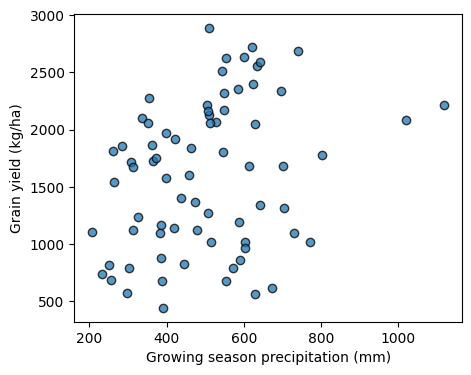

In [3]:
# Explore data
plt.figure(figsize=(5,4))
plt.scatter(df["rainfall"], df["grain_yield"], edgecolor='k', alpha=0.75)
plt.xlabel('Growing season precipitation (mm)')
plt.ylabel('Grain yield (kg/ha)')
plt.show()


## Binning process

Our next step is to partition the dataset into continuous and non-overlapping rainfall intervals or histogram bins.


In [4]:
# Get histogram bin edges
bin_edges = np.histogram_bin_edges(df['rainfall'], bins='fd')
print(bin_edges)


[ 206.629       308.01733333  409.40566667  510.794       612.18233333
  713.57066667  814.959       916.34733333 1017.73566667 1119.124     ]


The next step consists of iterating over each bin and get a specified yield percentile for the values in each bin and compute the average growing season rainfall for each bin.

In [17]:
# Initiate arrays filled with NaNs
yield_bin = np.full(len(bin_edges), np.nan)
rainfall_bin = np.full(len(bin_edges), np.nan)

# Loop over each rainfall bin
for k in range(len(bin_edges)-1):
    idx = (df['rainfall'] >= bin_edges[k]) & (df['rainfall'] < bin_edges[k+1])
    
    # If not rainfall observation is within current bin, then skip
    if np.all(idx == False):
        continue
        
    else:
        yield_bin[k] = df.loc[idx, 'grain_yield'].quantile(0.99)
        rainfall_bin[k] = df.loc[idx, 'rainfall'].mean()


# Display outputs. For simplicity I rounded the outputs at the time of printing.
print(rainfall_bin)
print(yield_bin)


[ 266.2301      363.7915      471.59007692  564.86611765  653.68054545
  760.57125              nan           nan 1020.064                nan]
[1851.37435097 2246.5035833  2809.38967096 2632.4922162  2708.5742522
 2661.1910059            nan           nan 2083.518656             nan]


In [18]:
# Remove bins with NaNs
idx_nan = np.isnan(rainfall_bin)
rainfall_bin = rainfall_bin[~idx_nan]
yield_bin = yield_bin[~idx_nan]


## Curve fitting

In the last step we need to create the frontier production function using the pairwise rainfall-yield data that we just collected for the rainfall bins.

In [19]:
# Define Cobb-Douglas model
cobb_douglas = lambda x, a, b, c: a + b * np.log(x) + c * np.log(x)**2

# Define initial guess for the parameters of the Cobb-Douglas model
par0 = [1,1,1]

# Fit Cobb-Douglas model
par = curve_fit(cobb_douglas, rainfall_bin, yield_bin, par0)
print('Optimized parameters:', np.round(par[0]))

# Create range of x values using a step increase (default). This will give us enough detail
# to have an accurate curve for most practical purposes.
frontier_rainfall = np.arange(0, df['rainfall'].max())
frontier_yield = cobb_douglas(frontier_rainfall, *par[0])

print('The frontier was built using a total of:', len(frontier_rainfall), 'points')


Optimized parameters: [-64574.  21257.  -1679.]
The frontier was built using a total of: 1120 points


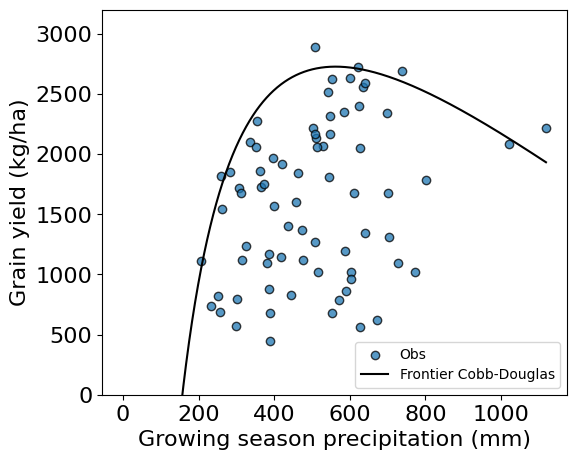

In [28]:
# Plot the data and frontier
plt.figure(figsize=(6,5))
plt.scatter(df["rainfall"], df["grain_yield"],
            edgecolor='k', alpha=0.75, label='Obs')
plt.plot(frontier_rainfall, frontier_yield,
         '-k', label='Frontier Cobb-Douglas')
plt.xlabel('Growing season precipitation (mm)', size=16)
plt.ylabel('Grain yield (kg/ha)', size=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,3200)
plt.legend(loc='lower right')
plt.show()


## Curve interpretation

- Part of the frontier function is negative. We limited the `y` axis in the plot to positive yield values.

- The part of the frontier yield function that intercepts the `x` axis represents the amount of growing season water supply that generates zero yield. This can be viewed as an inefficiency of the system and represents the minimum water losses due to runoff, evaporation, drainage, canopy interception, etc.

- The highest point of the curve indicates the growing season rainfall required to achieve maximum yield. Values below the curve represent non-optimal yield for that growing season rainfall, which can be associated to other factors such as the distribution of the rainfall during the growing season, heat stress, hail damage, or yield losses due to diseases and pests.

- The decaying portion of the curve at high growing season rainfall may be due to: 1) there is insuficient yield data for years with high growing season rainfall or 2) excess water is detrimental to grain yields (e.g., plant lodging, increased disease pressure, weaker root anchoring, and even larger number of cloudy days that reduce the amount of solar radiation for photosynthesis).


## Additional summary metrics

In [21]:
# Median rainfall
median_rainfall = df['rainfall'].median()
print(median_rainfall, 'mm')

# Median grain yield
median_yield = df['grain_yield'].median()
print(median_yield, 'kg/ha')

# Estimate minimum_losses using the Newton-Raphson method
minimum_losses = newton(cobb_douglas, 200, args=par[0])
print('Minimum losses: ', round(minimum_losses), 'mm')

# Find rainfall for highest grain yield
max_yield = np.amax(frontier_yield)
idx_max_yield = np.argmax(frontier_yield)
optimal_rainfall = frontier_rainfall[idx_max_yield]

print('Optimal rainfall:', round(optimal_rainfall), 'mm')
print('Optimal yield:', round(max_yield), 'kg/ha')


508.254 mm
1680.25698 kg/ha
Minimum losses:  157 mm
Optimal rainfall: 562 mm
Optimal yield: 2727 kg/ha


## Compute frontier with plateau

Some researchers prefer to fit a frontier with a plateau. While this is typically done using a two-segment piecewise linear model, we can easily adapt the model fitted earlier to achieve the same.

In [22]:
# Set maximum
idx_rainfall = frontier_rainfall > optimal_rainfall
frontier_plateau = frontier_yield.copy()
frontier_plateau[idx_rainfall] = np.maximum(frontier_plateau[idx_rainfall], max_yield)


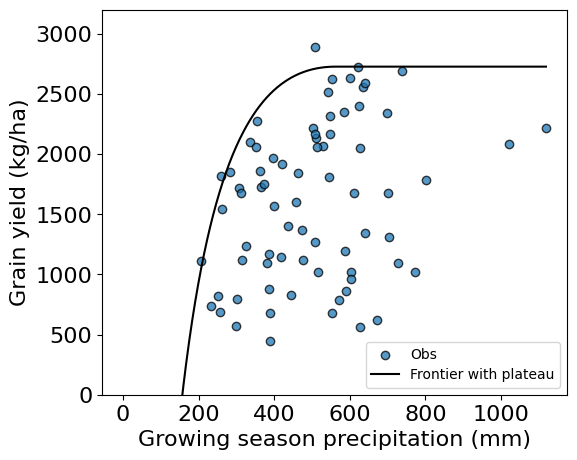

In [29]:
# Plot the new frontier
plt.figure(figsize=(6,5))
plt.scatter(df["rainfall"], df["grain_yield"], 
            edgecolor='k', alpha=0.75, label='Obs')
plt.plot(frontier_rainfall, frontier_plateau, 
         '-k', label='Frontier with plateau')
plt.xlabel('Growing season precipitation (mm)', size=16)
plt.ylabel('Grain yield (kg/ha)', size=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,3200)
plt.legend(loc='lower right')
plt.show()

## Practice

- Run the code again using a different method to create bins and a different percentile for yield in each bin. How different are the values for minimum losses and optimum rainfall amounts?


## References

Cobb, C.W. and Douglas, P.H., 1928. A theory of production. The American Economic Review, 18(1), pp.139-165.

French, R.J. and Schultz, J.E., 1984. Water use efficiency of wheat in a Mediterranean-type environment. I. The relation between yield, water use and climate. Australian Journal of Agricultural Research, 35(6), pp.743-764.

Grassini, P., Yang, H. and Cassman, K.G., 2009. Limits to maize productivity in Western Corn-Belt: a simulation analysis for fully irrigated and rainfed conditions. Agricultural and forest meteorology, 149(8), pp.1254-1265.

Patrignani, A., Lollato, R.P., Ochsner, T.E., Godsey, C.B. and Edwards, J., 2014. Yield gap and production gap of rainfed winter wheat in the southern Great Plains. Agronomy Journal, 106(4), pp.1329-1339.

